In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
adata = sc.read(os.path.join(datadir, "anca_samples_annotated_v2.h5ad"))

In [3]:
#%autoreload 2

import scanpy as sc
import pandas as pd
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import os#
import networkx as nx
from tqdm import tqdm

from spatial import *

In [4]:
adata_list = split_by_col(adata, col="Sample", verbose=False)

100%|██████████| 19/19 [00:04<00:00,  4.08it/s]


In [5]:
G, global_adj_mat, global_dist_mat, adj_mats, dist_mats = construct_batch_graph_visium(
    adata,
    batch_col="Sample",
    adata_list=None,
    output_intermediate_data=True,
    allow_self_loops=False,
)

Unpacking samples...


100%|██████████| 19/19 [00:04<00:00,  4.05it/s]


Constructing adjacency matrix...


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Constructing graph...
The average degree of the graph is 5.12.


In [6]:
adj_mats[1].shape

(678, 678)

In [7]:
adata.obsp["spatial_connectivities"] = csr_matrix(global_adj_mat)
adata.obsp["spatial_distances"] = csr_matrix(global_dist_mat)

  0%|          | 0/1000 [00:00<?, ?/s]

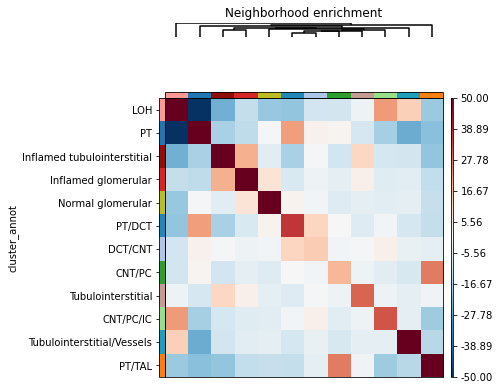

In [8]:
sq.gr.nhood_enrichment(adata, cluster_key="cluster_annot")
sq.pl.nhood_enrichment(
    adata,
    cluster_key="cluster_annot",
    method="average",
    cmap="RdBu_r",
    # vmin=-50,
    # vmax="p99",
    vmin=-50,
    vmax=50,
    figsize=(5, 5),
    save="nbd_enrichment.pdf"
)

In [9]:
adata_combined = adata.copy()

In [10]:
cluster_key = "cluster_annot"
nb_distances = adata_combined.uns["cluster_annot_nhood_enrichment"]["zscore"]

threshold = 0
nb_adj_mat = (nb_distances > threshold).astype(int)
nb_dist_mat = nb_distances * nb_adj_mat

nb_graph = nx.Graph(nb_adj_mat)

clusters = adata_combined.obs[cluster_key].unique().tolist()
clusters = adata_combined.obs[cluster_key].cat.categories.tolist()

labels = {i: label for i, label in enumerate(clusters)}

for i in range(nb_dist_mat.shape[0]):
    for j in range(i, nb_dist_mat.shape[0]):  # Ensures we only update each edge once
        if nb_graph.has_edge(i, j):
            nb_graph[i][j]["weight"] = nb_dist_mat[i][j]
        # else:
        #     print(f"Edge {i}-{j} not in G")

# Get the tab20 colormap from seaborn
colors_tab20 = sns.color_palette("tab20", len(labels))

# Define a mapping of node labels to colors
color_map = {label: colors_tab20[i] for i, label in enumerate(labels.values())}

# Get colors for each node
node_colors = [color_map[labels[node]] for node in nb_graph.nodes()]

nb_graph.remove_edges_from(nx.selfloop_edges(nb_graph))

In [11]:
nodesizes = adata.obs["cluster_annot"].value_counts()[list(labels.values())].tolist()

In [12]:
import pickle
with open("../data/cluster_annot_colors.pkl", "rb") as handle:
    color_map = pickle.load(handle)

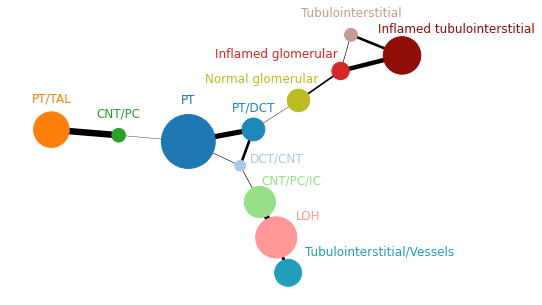

In [32]:
edge_weights = [d["weight"]*0.25 for _, _, d in nb_graph.edges(data=True)]
pos = nx.nx_agraph.graphviz_layout(nb_graph)#, weight="weight", scale=1) # nx.kamada_kawai_layout(nb_graph, weight="weight", scale=1)
# pos = nx.circular_layout(nb_graph, scale=1) 


# Draw the graph using the computed positions.
# You can customize the drawing by adjusting node sizes, colors, etc.
nx.draw(
    nb_graph,
    pos,
    with_labels=False,
    node_size=nodesizes, #700,
    node_color= color_map.values(),#node_colors,
    # font_weight="bold",
    width=edge_weights,
    edge_color="black",
    labels=labels,
)

for key in pos:
    x, y = pos[key]
    label = labels[key]
    if label == "PT":
        y = y+20
    elif label =="Normal glomerular":
        x = x-40
        y = y-20
    elif label =="Inflamed glomerular":
        x = x-70
        y = y-30
    elif label =="Inflamed tubulointerstitial":
        x = x+60
        y = y-10
    elif label in ["Tubulointerstitial", "CNT/PC", "PT/DCT"]:
        y = y-20
    elif label in ["Tubulointerstitial/Vessels"]:
        y = y-20
        x = x + 100
    elif label in ["LOH", "CNT/PC/IC"]:
        y = y-20
        x = x + 35
    elif label in ["DCT/CNT"]:
        y = y-50
        x = x + 40
    
    plt.text(x,y+50,s=label, 
             horizontalalignment='center',
             va="bottom", color=color_map[label],
            fontsize=12)


# Draw edge labels showing weights
edge_labels = dict(
    [
        (
            (
                u,
                v,
            ),
            d["weight"],
        )
        for u, v, d in nb_graph.edges(data=True)
    ]
)

T = nx.minimum_spanning_tree(nb_graph)


# texts = nx.draw_networkx_edge_labels(nb_graph, pos, edge_labels=edge_labels)
# Add a legend
for label, color in color_map.items():
    plt.plot([0], [0], color=color, label=label)
#nx.draw_networkx_edges(T, pos, edge_color="black", width=2)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(figdir, "graph-cluster_annot.pdf"), bbox_inches="tight")
plt.show()
